# Anticipez les besoins en consommation électrique de bâtiments

* Ville neutre en emissione de carbonne en 2050  
* Prédire les émission de co2 et la consommation totale d'énergie des batiments pour lesquelles pas de mesure  
* Évaluer l'interet de l'ENERGY STAR SCORE pour la prédiction d'émissions

* **1. Réaliser une courte analyse exploratoire**  
* **2. Tester différents modèles de prédiction afin de réponf=dre au mieux à la problématique**
* **3. Attention à la fuite de données**

* choisir les variables à utiliser
* data leak
* regresseur differents (min 1 linéaire, 1 non linéaire
* validation croisée lors de l'optimisation des hyperparams
* justifier le choix de l'un des regresseurs
* choisir métrique poour l'optimisation
* Explorer differents score et indic de performances
* présentation du plus simple au plus complexe
* encodage adapté des var catégorielles
* Normalisation des variables ou transformation de leur distrib si besoin

In [1]:
import dill
dill.load_session('kernels/p4_explor_kernel.db')

In [1]:
import os

import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from scipy.stats import shapiro

In [2]:
pd.set_option("display.max_colwidth", 1000)

## 1. IMPORT DES DONNÉES

In [3]:
df_2015 = pd.read_csv(r'D:\Work\OC_DS_P4\2015-building-energy-benchmarking.csv')
df_2016 = pd.read_csv(r'D:\Work\OC_DS_P4\2016-building-energy-benchmarking.csv')

In [ ]:
df_2015 = pd.read_csv(r'E:\t\Cours Open Classeroom\DATA SCIENCE\Projet 4\data\2015-building-energy-benchmarking.csv')
df_2016 = pd.read_csv(r'E:\t\Cours Open Classeroom\DATA SCIENCE\Projet 4\data\2016-building-energy-benchmarking.csv')

In [3]:
df_2015 = pd.read_csv(r'C:\Users\t.favrel\Downloads\data p4\2015-building-energy-benchmarking.csv')
df_2016 = pd.read_csv(r'C:\Users\t.favrel\Downloads\data p4\2016-building-energy-benchmarking.csv')

In [4]:
with open(r'D:\Work\OC_DS_P4\socrata_metadata_2015-building-energy-benchmarking.json') as json_data:
    metaData_2015 = json.load(json_data)
    
with open(r'D:\Work\OC_DS_P4\socrata_metadata_2016-building-energy-benchmarking.json') as json_data:
    metaData_2016 = json.load(json_data)

In [5]:
# Données relatives aux colonnes
meta_col_2015 = pd.DataFrame.from_dict(metaData_2015['columns'])
meta_col_2016 = pd.DataFrame.from_dict(metaData_2016['columns'])

## 2. APERÇU DES DONNÉES

In [4]:
def df_display_shape(df, name='_'):
    '''
    Affiche le nombre de lignes et de colonnes d'un DataFrame
    '''
    if name != '_':
        print(f'{name} contient {df.shape[0]} lignes et {df.shape[1]} colonnes')
    else:
        print(f'Le DataFrame contient {df.shape[0]} lignes et {df.shape[1]} colonnes')

In [5]:
df_display_shape(df_2015)
df_2015.head(4)

Le DataFrame contient 3340 lignes et 47 colonnes


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{""address"": ""405 OLIVE WAY"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122.33335756', 'human_address': '{""address"": ""724 PINE ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1996,...,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122.33769944', 'human_address': '{""address"": ""1900 5TH AVE"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1969,...,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122.33660889', 'human_address': '{""address"": ""620 STEWART ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1926,...,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081


In [6]:
df_display_shape(df_2016)
df_2016.head(4)

Le DataFrame contient 3376 lignes et 46 colonnes


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67


### 2.a Colonnes 

In [7]:
col_2015 = set(df_2015.columns)
col_2016 = set(df_2016.columns)

In [8]:
inter = col_2015.intersection(col_2016) # Dans 2015 et 2016
only_2015 = col_2015.difference(col_2016) # Uniquement dans 2015
only_2016 = col_2016.difference(col_2015) # Uniquement dans 2016

In [9]:
print(f"Il y a {len(inter)} colonnes présentes en 2015 et 2016\n\
Il y a {len(only_2015)} colonnes uniquement en 2015 et {len(only_2016)} colonnes uniquement en 2016.")

Il y a 37 colonnes présentes en 2015 et 2016
Il y a 10 colonnes uniquement en 2015 et 9 colonnes uniquement en 2016.


In [10]:
inter, only_2015, only_2016

({'BuildingType',
  'ComplianceStatus',
  'CouncilDistrictCode',
  'DataYear',
  'DefaultData',
  'ENERGYSTARScore',
  'Electricity(kBtu)',
  'Electricity(kWh)',
  'LargestPropertyUseType',
  'LargestPropertyUseTypeGFA',
  'ListOfAllPropertyUseTypes',
  'NaturalGas(kBtu)',
  'NaturalGas(therms)',
  'Neighborhood',
  'NumberofBuildings',
  'NumberofFloors',
  'OSEBuildingID',
  'Outlier',
  'PrimaryPropertyType',
  'PropertyGFABuilding(s)',
  'PropertyGFAParking',
  'PropertyGFATotal',
  'PropertyName',
  'SecondLargestPropertyUseType',
  'SecondLargestPropertyUseTypeGFA',
  'SiteEUI(kBtu/sf)',
  'SiteEUIWN(kBtu/sf)',
  'SiteEnergyUse(kBtu)',
  'SiteEnergyUseWN(kBtu)',
  'SourceEUI(kBtu/sf)',
  'SourceEUIWN(kBtu/sf)',
  'SteamUse(kBtu)',
  'TaxParcelIdentificationNumber',
  'ThirdLargestPropertyUseType',
  'ThirdLargestPropertyUseTypeGFA',
  'YearBuilt',
  'YearsENERGYSTARCertified'},
 {'2010 Census Tracts',
  'City Council Districts',
  'Comment',
  'GHGEmissions(MetricTonsCO2e)',
  'G

In [11]:
df_2015.loc[:, ['Zip Codes', 'OSEBuildingID']]

,Zip Codes,OSEBuildingID
0,18081,1
1,18081,2
2,18081,3
3,18081,5
4,19576,8
...,...,...
3335,18379,50049
3336,18383,50055
3337,19576,50057
3338,18792,50058


In [14]:
meta_col_2015[meta_col_2015['name'] == 'Zip Codes']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
46,350404106,Zip Codes,number,NaN,:@computed_region_q256_3sug,51,number,62603795,NaN,NaN,{},"{'source_columns': ['location'], 'type': 'georegion_match_on_point', 'parameters': {'region': '_q256-3sug', 'primary_key': '_feature_id'}}"


In [12]:
df_2016.loc[:3339, ['ZipCode', 'OSEBuildingID']]

,ZipCode,OSEBuildingID
0,98101.0,1
1,98101.0,2
2,98101.0,3
3,98101.0,5
4,98121.0,8
...,...,...
3335,98115.0,50059
3336,98104.0,50061
3337,98103.0,50062
3338,98108.0,50068


In [13]:
df_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)' : 'TotalGHGEmissions'}
              ,inplace=True)

In [14]:
# On sépare la variable location en différentes variables pour être cohérente au df 2016
Adresse = df_2015['Location'].str.split(',',  expand= True)

#On enlève les caractères inutiles sur nos nouvelles variables
Adresse[0].replace("{'latitude': '","",regex=True,inplace=True)
Adresse[0].replace("'","",regex=True,inplace=True)

Adresse[1].replace("'longitude': '","",regex=True,inplace=True)
Adresse[1].replace("'","",regex=True,inplace=True)

Adresse[2].replace("'human_address':","",regex=True,inplace=True)
Adresse[2].replace("'","",regex=True,inplace=True)
Adresse[2].replace('{"address": "','',regex=True,inplace=True)
Adresse[2].replace('"','',regex=True,inplace=True)


Adresse[3].replace('"','',regex=True,inplace=True)
Adresse[3].replace('city: ','',regex=True,inplace=True)
Adresse[3].replace(' ','',regex=True,inplace=True)
Adresse[3] = Adresse[3].str.capitalize()

Adresse[4].replace('"state": "','',regex=True,inplace=True)
Adresse[4].replace('"','',regex=True,inplace=True)

Adresse[5].replace('"zip": "','',regex=True,inplace=True)
Adresse[5].replace('"}','',regex=True,inplace=True)
Adresse[5].replace("'}",'',regex=True,inplace=True)

Adresse.head(3)

,0,1,2,3,4,5
0,47.61219025,-122.33799744,405 OLIVE WAY,Seattle,WA,98101
1,47.61310583,-122.33335756,724 PINE ST,Seattle,WA,98101
2,47.61334897,-122.33769944,1900 5TH AVE,Seattle,WA,98101


In [15]:
# Conversion des variables latitude, longitude et Zip Code en float 64
Adresse[0] = pd.to_numeric(Adresse[0], errors='coerce')
Adresse[1] = pd.to_numeric(Adresse[1], errors='coerce')
Adresse[5] = pd.to_numeric(Adresse[5], errors='coerce')
Adresse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3340 non-null   float64
 1   1       3340 non-null   float64
 2   2       3340 non-null   object 
 3   3       3340 non-null   object 
 4   4       3340 non-null   object 
 5   5       3340 non-null   int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 156.7+ KB


In [16]:
#ON réintègre notre adresse séparée en plusieurs champs dans notre df_2015 et on renomme les variables de gaz a effet de serre
df_2015['Latitude'] = Adresse[0]
df_2015['Longitude'] = Adresse[1]
df_2015['Address'] = Adresse[2]
df_2015['City'] = Adresse[3]
df_2015['State'] = Adresse[4]
df_2015['ZipCode'] = Adresse[5]

df_2015.drop(columns =["Location"], inplace = True) 

df_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions', \
                        'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity',\
                       'Comment':'Comments'}, inplace=True)
df_2015.head(1)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,Latitude,Longitude,Address,City,State,ZipCode
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1,...,14.0,NaN,31.0,18081,47.61219,-122.337997,405 OLIVE WAY,Seattle,WA,98101


### 2.b Lignes - ID

In [17]:
ID_2015 = set(df_2015['OSEBuildingID'])
ID_2016 = set(df_2016['OSEBuildingID'])

In [18]:
ID_inter = ID_2015.intersection(ID_2016) # Dans 2015 et 2016
ID_only_2015 = ID_2015.difference(ID_2016) # Uniquement dans 2015
ID_only_2016 = ID_2016.difference(ID_2015) # Uniquement dans 2016

In [19]:
meta_col_2015.loc[meta_col_2015['name'] == 'OSEBuildingID', 'description']

NameError: name 'meta_col_2015' is not defined

In [20]:
print(f"Il y a {len(ID_inter)} ID présentes en 2015 et 2016\n\
Il y a {len(ID_only_2015)} ID uniquement en 2015 et {len(ID_only_2016)} ID uniquement en 2016.")

Il y a 3284 ID présentes en 2015 et 2016
Il y a 56 ID uniquement en 2015 et 92 ID uniquement en 2016.


## 3. COMPLÉTUDE

In [21]:
def show_values_on_bars(axs, vertical=True, space=0.4):
    """
    Affiche les valeurs d'un barplot.
    """
    def _show_on_single_plot(ax):
        if vertical == True:
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + space
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif vertical == False:
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + space
                _y = p.get_y() + p.get_height() / 2
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [22]:
def display_filling_of_col(df, line=0, color='#3556C8', figsize=(8, 5), show_values=False):
    df_tmp = pd.DataFrame()
    for col in df.columns:
        df_tmp[col] = pd.Series(df[col].count())
    x = list(df_tmp.T.sort_values(by=0, ascending=False)[0] / df.shape[0] * 100)
    y = list(df_tmp.T.sort_values(by=0, ascending=False).index)
    fig, ax = plt.subplots(figsize=figsize)
    if line == 0:
        sns.barplot(x=x, 
                    y=y,
                   orient='h', color=color)
    else:
        sns.barplot(x=x[:line], 
                    y=y[:line],
                   orient='h', color=color)
    if show_values == True:
        show_values_on_bars(ax, vertical=False)

In [23]:
def filling_rate(dataframe, name='Dataframe'):
    """Calcuates and displays the shape of the dataframe and the filling rate"""
    
    sns.set()
    
    nb_rows, nb_columns = dataframe.shape
    nb_data = dataframe.count().sum()

    filling_rate = nb_data / (nb_rows * nb_columns)
    print(f"The global filling rate of the {name} is : {filling_rate:.2%}")
      
    frequencies = [filling_rate, 1 - filling_rate]
    labels = ["Filled data", "Missing data"]
    
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title("Filling of the DataFrame", fontsize=25)
    ax.axis("equal")

    ax.pie(frequencies,
           autopct='%1.2f%%',
           colors=['#6C5DD8', '#94E5E2']
          )
    plt.legend(labels)

### 3.a 2015

The global filling rate of the Dataframe is : 84.74%


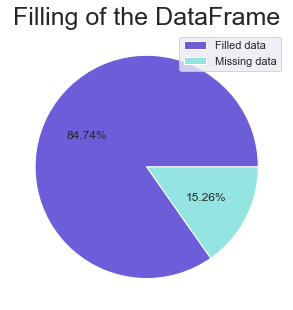

In [24]:
filling_rate(df_2015)

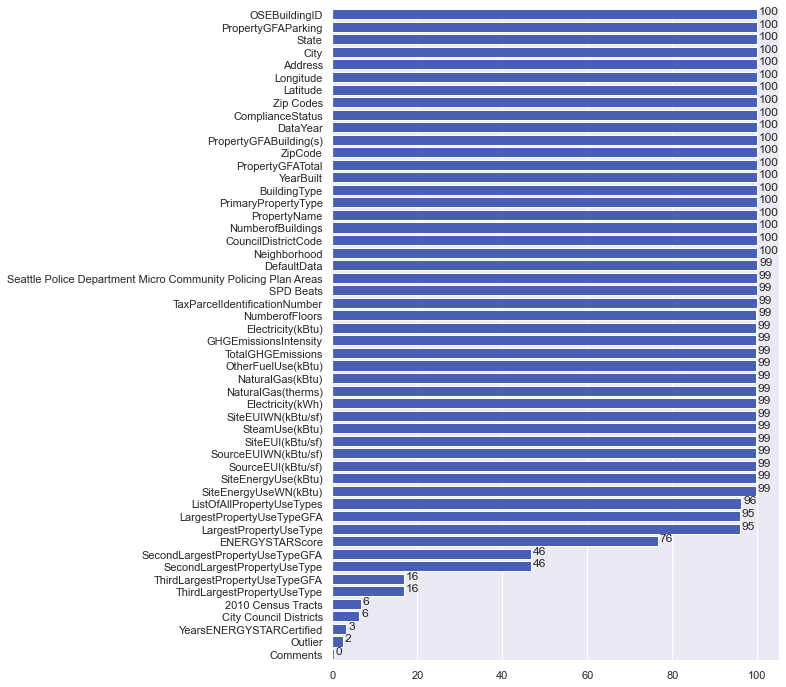

In [25]:
display_filling_of_col(df_2015, show_values=True, figsize=(8, 12))

### 3.b 2016

The global filling rate of the Dataframe is : 87.15%


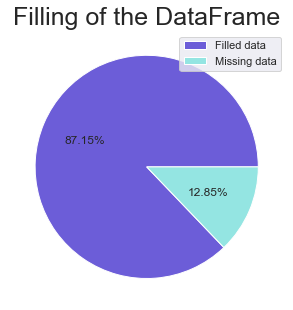

In [26]:
filling_rate(df_2016)

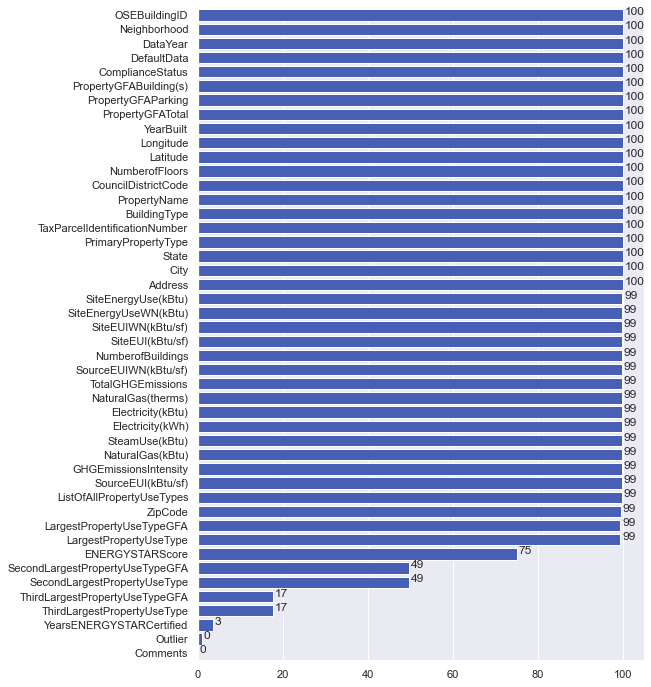

In [27]:
display_filling_of_col(df_2016, show_values=True, figsize=(8, 12))

## 4. EXPLICATIONS DES VARIABLES

In [33]:
inter, only_2015, only_2016

({'BuildingType',
  'ComplianceStatus',
  'CouncilDistrictCode',
  'DataYear',
  'DefaultData',
  'ENERGYSTARScore',
  'Electricity(kBtu)',
  'Electricity(kWh)',
  'LargestPropertyUseType',
  'LargestPropertyUseTypeGFA',
  'ListOfAllPropertyUseTypes',
  'NaturalGas(kBtu)',
  'NaturalGas(therms)',
  'Neighborhood',
  'NumberofBuildings',
  'NumberofFloors',
  'OSEBuildingID',
  'Outlier',
  'PrimaryPropertyType',
  'PropertyGFABuilding(s)',
  'PropertyGFAParking',
  'PropertyGFATotal',
  'PropertyName',
  'SecondLargestPropertyUseType',
  'SecondLargestPropertyUseTypeGFA',
  'SiteEUI(kBtu/sf)',
  'SiteEUIWN(kBtu/sf)',
  'SiteEnergyUse(kBtu)',
  'SiteEnergyUseWN(kBtu)',
  'SourceEUI(kBtu/sf)',
  'SourceEUIWN(kBtu/sf)',
  'SteamUse(kBtu)',
  'TaxParcelIdentificationNumber',
  'ThirdLargestPropertyUseType',
  'ThirdLargestPropertyUseTypeGFA',
  'YearBuilt',
  'YearsENERGYSTARCertified'},
 {'2010 Census Tracts',
  'City Council Districts',
  'Comment',
  'GHGEmissions(MetricTonsCO2e)',
  'G

**1. ENERGYSTARScore :  
Note de 1 à 100 qui évalue la performance énergétique globale d'une propriété. Un score de 50 représente la médiane nationale.**

In [30]:
meta_col_2015[meta_col_2015['name'] == 'ENERGYSTARScore']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
23,350402322,ENERGYSTARScore,number,"An EPA calculated 1-100 rating that assesses a property’s overall energy performance, based on national data to control for differences among climate, building uses, and operations. A score of 50 represents the national median.",energystarscore,28,number,46302845,280.0,"{'largest': '100.00', 'non_null': 2560, 'average': '67.894140625', 'null': '780', 'top': [{'item': '100.00', 'count': '106'}, {'item': '95.00', 'count': '79'}, {'item': '94.00', 'count': '70'}, {'item': '97.00', 'count': '60'}, {'item': '99', 'count': '59'}, {'item': '93.00', 'count': '56'}, {'item': '81.00', 'count': '56'}, {'item': '98.00', 'count': '54'}, {'item': '89.00', 'count': '54'}, {'item': '86.00', 'count': '52'}, {'item': '85.00', 'count': '52'}, {'item': '91.00', 'count': '51'}, {'item': '92.00', 'count': '50'}, {'item': '88.00', 'count': '49'}, {'item': '83', 'count': '48'}, {'item': '84.00', 'count': '46'}, {'item': '77.00', 'count': '44'}, {'item': '90.00', 'count': '44'}, {'item': '79.00', 'count': '43'}, {'item': '1', 'count': '42'}], 'smallest': '1.00', 'not_null': '2560', 'sum': '173809.00', 'cardinality': '100'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**2. Electricity(kBtu) :  
La quantité annuelle d'électricité consommée par la propriété sur place, y compris l'électricité achetée au réseau et produite par des systèmes renouvelables sur place, mesurée en milliers d'unités thermiques britanniques (kBtu).**

In [31]:
meta_col_2015[meta_col_2015['name'] == 'Electricity(kBtu)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
32,350402331,Electricity(kBtu),number,"\t\nThe annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in thousands of British thermal units (kBtu).",electricity_kbtu,37,number,46302854,304.0,"{'largest': '284726322', 'non_null': 3330, 'average': '3473209.381081081', 'null': '10', 'top': [{'item': '0', 'count': '2'}, {'item': '6581', 'count': '1'}, {'item': '497152', 'count': '1'}, {'item': '11442', 'count': '1'}, {'item': '17150', 'count': '1'}, {'item': '24127', 'count': '1'}, {'item': '329910', 'count': '1'}, {'item': '39033', 'count': '1'}, {'item': '42652', 'count': '1'}, {'item': '43945', 'count': '1'}, {'item': '50897', 'count': '1'}, {'item': '53404', 'count': '1'}, {'item': '64880', 'count': '1'}, {'item': '68982', 'count': '1'}, {'item': '228142', 'count': '1'}, {'item': '74704', 'count': '1'}, {'item': '75200', 'count': '1'}, {'item': '75306', 'count': '1'}, {'item': '76078', 'count': '1'}, {'item': '84073', 'count': '1'}], 'smallest': '0', 'not_null': '3330', 'sum': '11565787239', 'cardinality': '3329'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**3. Electricity(kWh):  
Electricity(kBtu) en kWh.**

In [32]:
meta_col_2015[meta_col_2015['name'] == 'Electricity(kWh)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
31,350402330,Electricity(kWh),number,"\t\nThe annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in kWh.",electricity_kwh,36,number,46302853,292.0,"{'largest': '83445048', 'non_null': 3330, 'average': '1017897.224924925', 'null': '10', 'top': [{'item': '0', 'count': '2'}, {'item': '221628', 'count': '2'}, {'item': '340715', 'count': '2'}, {'item': '1929', 'count': '1'}, {'item': '5026', 'count': '1'}, {'item': '7071', 'count': '1'}, {'item': '3353', 'count': '1'}, {'item': '11440', 'count': '1'}, {'item': '12500', 'count': '1'}, {'item': '12879', 'count': '1'}, {'item': '14916', 'count': '1'}, {'item': '15651', 'count': '1'}, {'item': '19015', 'count': '1'}, {'item': '20217', 'count': '1'}, {'item': '21894', 'count': '1'}, {'item': '30438', 'count': '1'}, {'item': '22039', 'count': '1'}, {'item': '22070', 'count': '1'}, {'item': '22296', 'count': '1'}, {'item': '24639', 'count': '1'}], 'smallest': '0', 'not_null': '3330', 'sum': '3389597759', 'cardinality': '3327'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**4. NaturalGas(therms) :
La quantité annuelle de gaz naturel fourni par les services publics consommée par la propriété, mesurée en thermes.**

In [33]:
meta_col_2015[meta_col_2015['name'] == 'NaturalGas(therms)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
33,350402332,NaturalGas(therms),number,"The annual amount of utility-supplied natural gas consumed by the property, measured in therms.",naturalgas_therms,38,number,46302855,316.0,"{'largest': '1364484', 'non_null': 3330, 'average': '12533.04474474474', 'null': '10', 'top': [{'item': '0', 'count': '1256'}, {'item': '7584', 'count': '3'}, {'item': '2', 'count': '3'}, {'item': '10', 'count': '3'}, {'item': '4789', 'count': '3'}, {'item': '865', 'count': '2'}, {'item': '8856', 'count': '2'}, {'item': '12923', 'count': '2'}, {'item': '3019', 'count': '2'}, {'item': '7426', 'count': '2'}, {'item': '3229', 'count': '2'}, {'item': '417', 'count': '2'}, {'item': '6819', 'count': '2'}, {'item': '6880', 'count': '2'}, {'item': '11794', 'count': '2'}, {'item': '5088', 'count': '2'}, {'item': '1092', 'count': '2'}, {'item': '3479', 'count': '2'}, {'item': '1', 'count': '2'}, {'item': '23334', 'count': '2'}], 'smallest': '0', 'not_null': '3330', 'sum': '41735039', 'cardinality': '1995'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**5. PropertyGFABuilding(s) :  
Surface totale au sol en pieds carrés entre les surfaces extérieures des murs d’enceinte d’un bâtiment. Cela comprend toutes les zones à l'intérieur du ou des bâtiments, telles que l'espace des locataires, les espaces communs, les cages d'escalier, les sous-sols, le stockage, etc.**

In [34]:
meta_col_2015[meta_col_2015['name'] == 'PropertyGFABuilding(s)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
14,350402313,PropertyGFABuilding(s),number,"Total floor space in square feet between the outside surfaces of a building’s enclosing walls. This includes all areas inside the building(s), such as tenant space, common areas, stairwells, basements, storage, etc.",propertygfabuilding_s,19,number,46302836,364.0,"{'largest': '2200000', 'non_null': 3340, 'average': '79718.86047904192', 'null': '0', 'top': [{'item': '21600', 'count': '9'}, {'item': '25920', 'count': '8'}, {'item': '36000', 'count': '7'}, {'item': '28800', 'count': '7'}, {'item': '24000', 'count': '6'}, {'item': '30720', 'count': '4'}, {'item': '22320', 'count': '4'}, {'item': '23100', 'count': '3'}, {'item': '21200', 'count': '3'}, {'item': '22344', 'count': '3'}, {'item': '25200', 'count': '3'}, {'item': '30000', 'count': '3'}, {'item': '24288', 'count': '3'}, {'item': '33300', 'count': '3'}, {'item': '21900', 'count': '3'}, {'item': '30240', 'count': '3'}, {'item': '20000', 'count': '3'}, {'item': '25800', 'count': '3'}, {'item': '24100', 'count': '2'}, {'item': '40800', 'count': '2'}], 'smallest': '-50550', 'not_null': '3340', 'sum': '266260994', 'cardinality': '3145'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**6. PropertyGFAParking :  
Espace total en pieds carrés de tous les types de stationnement (entièrement clos, partiellement clos et ouvert).**

In [35]:
meta_col_2015[meta_col_2015['name'] == 'PropertyGFAParking']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
13,350402312,PropertyGFAParking,number,"Total space in square feet of all types of parking (Fully Enclosed, Partially Enclosed, and Open).",propertygfaparking,18,number,46302835,316.0,"{'largest': '512608', 'non_null': 3340, 'average': '11054.03233532934', 'null': '0', 'top': [{'item': '0', 'count': '2416'}, {'item': '25920', 'count': '3'}, {'item': '13320', 'count': '3'}, {'item': '12960', 'count': '2'}, {'item': '10800', 'count': '2'}, {'item': '6034', 'count': '2'}, {'item': '20416', 'count': '2'}, {'item': '30000', 'count': '2'}, {'item': '25800', 'count': '2'}, {'item': '22000', 'count': '2'}, {'item': '11544', 'count': '2'}, {'item': '100176', 'count': '2'}, {'item': '3000', 'count': '2'}, {'item': '24000', 'count': '2'}, {'item': '12044', 'count': '2'}, {'item': '6300', 'count': '2'}, {'item': '1496', 'count': '1'}, {'item': '1559', 'count': '1'}, {'item': '1730', 'count': '1'}, {'item': '1774', 'count': '1'}], 'smallest': '-3', 'not_null': '3340', 'sum': '36920468', 'cardinality': '908'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**7. SiteEUI(kBtu/sf) :  
L'intensité énergétique du site (IUE) est la consommation énergétique du site d'un établissement divisée par sa surface de plancher brute. La consommation d'énergie du site est la quantité annuelle de toute l'énergie consommée par la propriété sur place, comme indiqué sur les factures de services publics. L'IUE du site est mesurée en milliers d'unités thermiques britanniques (kBtu) par pied carré.**

In [36]:
meta_col_2015[meta_col_2015['name'] == 'SiteEUI(kBtu/sf)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
24,350402323,SiteEUI(kBtu/sf),number,"Site Energy Use Intensity (EUI) is a property's Site Energy Use divided by its gross floor area. Site Energy Use is the annual amount of all the energy consumed by the property on-site, as reported on utility bills. Site EUI is measured in thousands of British thermal units (kBtu) per square foot.",siteeui_kbtu_sf,29,number,46302846,292.0,"{'largest': '800.60', 'non_null': 3330, 'average': '53.62612612612613', 'null': '10', 'top': [{'item': '27.20', 'count': '18'}, {'item': '28.50', 'count': '16'}, {'item': '29.30', 'count': '16'}, {'item': '29.60', 'count': '16'}, {'item': '24.70', 'count': '15'}, {'item': '29.80', 'count': '15'}, {'item': '27.90', 'count': '15'}, {'item': '30.40', 'count': '14'}, {'item': '28.90', 'count': '14'}, {'item': '27.80', 'count': '13'}, {'item': '26.80', 'count': '13'}, {'item': '26.30', 'count': '13'}, {'item': '31.40', 'count': '12'}, {'item': '27.00', 'count': '12'}, {'item': '31.00', 'count': '12'}, {'item': '37.30', 'count': '12'}, {'item': '32.40', 'count': '12'}, {'item': '26.00', 'count': '12'}, {'item': '25.30', 'count': '12'}, {'item': '25.10', 'count': '12'}], 'smallest': '0.00', 'not_null': '3330', 'sum': '178575.00', 'cardinality': '1072'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**8. SiteEUIWN(kBtu/sf) :  
L'intensité d'utilisation de l'énergie du site normalisée selon les conditions météorologiques (WN) correspond à l'énergie du site WN d'une propriété divisée par sa surface de plancher brute (en pieds carrés). L'énergie du site WN est la consommation d'énergie du site que la propriété aurait consommée pendant 30 ans dans des conditions météorologiques moyennes. WN Site EUI est mesuré en mesuré en milliers d'unités thermiques britanniques (kBtu) par pied carré.**

In [37]:
meta_col_2015[meta_col_2015['name'] == 'SiteEUIWN(kBtu/sf)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
25,350402324,SiteEUIWN(kBtu/sf),number,\t\nWeather Normalized (WN) Site Energy Use Intensity (EUI) is a property's WN Site Energy divided by its gross floor area (in square feet). WN Site Energy is the Site Energy Use the property would have consumed during 30-year average weather conditions. WN Site EUI is measured in measured in thousands of British thermal units (kBtu) per square foot.,siteeuiwn_kbtu_sf,30,number,46302847,316.0,"{'largest': '800.60', 'non_null': 3330, 'average': '57.58654654654655', 'null': '10', 'top': [{'item': '29.60', 'count': '15'}, {'item': '29.70', 'count': '15'}, {'item': '25.00', 'count': '14'}, {'item': '32.30', 'count': '14'}, {'item': '26.50', 'count': '14'}, {'item': '29.80', 'count': '14'}, {'item': '30.50', 'count': '14'}, {'item': '30.60', 'count': '13'}, {'item': '35.90', 'count': '13'}, {'item': '29.30', 'count': '13'}, {'item': '32.70', 'count': '13'}, {'item': '28.30', 'count': '12'}, {'item': '39.30', 'count': '12'}, {'item': '33.00', 'count': '12'}, {'item': '31.40', 'count': '12'}, {'item': '30.40', 'count': '12'}, {'item': '29.00', 'count': '12'}, {'item': '0.00', 'count': '12'}, {'item': '27.20', 'count': '12'}, {'item': '26.00', 'count': '12'}], 'smallest': '0.00', 'not_null': '3330', 'sum': '191763.20', 'cardinality': '1115'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**9. SiteEnergyUse(kBtu) :  
La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie.**

In [38]:
meta_col_2015[meta_col_2015['name'] == 'SiteEnergyUse(kBtu)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
28,350402327,SiteEnergyUse(kBtu),number,\t\nThe annual amount of energy consumed by the property from all sources of energy.,siteenergyuse_kbtu,33,number,46302850,328.0,"{'largest': '295812640', 'non_null': 3330, 'average': '4983106.046246246', 'null': '10', 'top': [{'item': '0', 'count': '2'}, {'item': '2074152', 'count': '2'}, {'item': '767213', 'count': '2'}, {'item': '784584', 'count': '2'}, {'item': '53401', 'count': '1'}, {'item': '56493', 'count': '1'}, {'item': '17150', 'count': '1'}, {'item': '93802', 'count': '1'}, {'item': '43943', 'count': '1'}, {'item': '93851', 'count': '1'}, {'item': '94186', 'count': '1'}, {'item': '95544', 'count': '1'}, {'item': '108795', 'count': '1'}, {'item': '109014', 'count': '1'}, {'item': '131810', 'count': '1'}, {'item': '91996', 'count': '1'}, {'item': '194839', 'count': '1'}, {'item': '132105', 'count': '1'}, {'item': '133880', 'count': '1'}, {'item': '142873', 'count': '1'}], 'smallest': '0', 'not_null': '3330', 'sum': '16593743134', 'cardinality': '3326'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**10. SourceEUI(kBtu/sf) :  
L'intensité d'utilisation de l'énergie à la source (IUE) est la consommation d'énergie à la source d'une propriété divisée par sa surface de plancher brute. La consommation d'énergie à la source est l'énergie annuelle utilisée pour faire fonctionner la propriété, y compris les pertes liées à la production, au transport et à la distribution. La source EUI est mesurée en milliers d'unités thermiques britanniques (kBtu) par pied carré.**

In [39]:
meta_col_2015[meta_col_2015['name'] == 'SourceEUI(kBtu/sf)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
26,350402325,SourceEUI(kBtu/sf),number,"Source Energy Use Intensity (EUI) is a property's Source Energy Use divided by its gross floor area. Source Energy Use is the annual energy used to operate the property, including losses from generation, transmission, & distribution. Source EUI is measured in thousands of British thermal units (kBtu) per square foot.",sourceeui_kbtu_sf,31,number,46302848,316.0,"{'largest': '2511.10', 'non_null': 3330, 'average': '132.7797297297297', 'null': '10', 'top': [{'item': '65.70', 'count': '9'}, {'item': '81.30', 'count': '9'}, {'item': '78.40', 'count': '9'}, {'item': '68.40', 'count': '9'}, {'item': '78.60', 'count': '9'}, {'item': '74.70', 'count': '8'}, {'item': '100.10', 'count': '8'}, {'item': '83.60', 'count': '8'}, {'item': '81.40', 'count': '8'}, {'item': '93.00', 'count': '8'}, {'item': '75.20', 'count': '8'}, {'item': '69.40', 'count': '8'}, {'item': '69.50', 'count': '7'}, {'item': '105.20', 'count': '7'}, {'item': '85.60', 'count': '7'}, {'item': '79.10', 'count': '7'}, {'item': '85.40', 'count': '7'}, {'item': '94.10', 'count': '7'}, {'item': '66.60', 'count': '7'}, {'item': '84.70', 'count': '7'}], 'smallest': '-2.00', 'not_null': '3330', 'sum': '442156.50', 'cardinality': '1673'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**11. SteamUse(kBtu) :  
La quantité annuelle de vapeur consommée par la propriété sur place, mesurée en milliers d'unités thermiques britanniques (kBtu).**

In [40]:
meta_col_2015[meta_col_2015['name'] == 'SteamUse(kBtu)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
30,350402329,SteamUse(kBtu),number,"The annual amount of district steam consumed by the property on-site, measured in thousands of British thermal units (kBtu).",steamuse_kbtu,35,number,46302852,268.0,"{'largest': '127869744', 'non_null': 3330, 'average': '250285.0759759760', 'null': '10', 'top': [{'item': '0', 'count': '3200'}, {'item': '14089', 'count': '1'}, {'item': '138504', 'count': '1'}, {'item': '162514', 'count': '1'}, {'item': '184557', 'count': '1'}, {'item': '208000', 'count': '1'}, {'item': '216792', 'count': '1'}, {'item': '232000', 'count': '1'}, {'item': '296619', 'count': '1'}, {'item': '305664', 'count': '1'}, {'item': '310440', 'count': '1'}, {'item': '312366', 'count': '1'}, {'item': '368153', 'count': '1'}, {'item': '372528', 'count': '1'}, {'item': '383274', 'count': '1'}, {'item': '448146', 'count': '1'}, {'item': '456687', 'count': '1'}, {'item': '486182', 'count': '1'}, {'item': '505677', 'count': '1'}, {'item': '509178', 'count': '1'}], 'smallest': '0', 'not_null': '3330', 'sum': '833449303', 'cardinality': '131'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**12 . (2015) GHGEmissions(MetricTonsCO2e) // (2016) TotalGHGEmissions :  
La quantité totale d'émissions de gaz à effet de serre, y compris le dioxyde de carbone, le méthane et les gaz d'oxyde nitreux rejetés dans l'atmosphère à la suite de la consommation d'énergie de la propriété, mesurée en tonnes métriques d'équivalent dioxyde de carbone. Ce calcul utilise un facteur d'émissions de GES du portefeuille de ressources de production de Seattle CIty Light. Cela utilise le facteur d'émissions 2015 de Seattle City Light de 52,44 lbs CO2e / MWh. Facteur de vapeur Enwave = 170,17 lb CO2e / MMBtu. Facteur gaz provenant de l'EPA Portfolio Manager = 53,11 kg CO2e / MBtu.**

In [41]:
meta_col_2015[meta_col_2015['name'] == 'GHGEmissions(MetricTonsCO2e)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
36,350402335,GHGEmissions(MetricTonsCO2e),number,"The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.",ghgemissions_metrictonsco2e,41,number,46302858,436.0,"{'largest': '11824.89', 'non_null': 3330, 'average': '110.0941021021021', 'null': '10', 'top': [{'item': '4.65', 'count': '8'}, {'item': '3.47', 'count': '6'}, {'item': '3.54', 'count': '6'}, {'item': '4.55', 'count': '6'}, {'item': '6.71', 'count': '5'}, {'item': '4.73', 'count': '5'}, {'item': '4.26', 'count': '5'}, {'item': '3.62', 'count': '5'}, {'item': '5.87', 'count': '5'}, {'item': '3.98', 'count': '4'}, {'item': '4.44', 'count': '4'}, {'item': '6.19', 'count': '4'}, {'item': '4.32', 'count': '4'}, {'item': '9.83', 'count': '4'}, {'item': '11.82', 'count': '4'}, {'item': '3.34', 'count': '4'}, {'item': '4.86', 'count': '4'}, {'item': '5.35', 'count': '4'}, {'item': '4.25', 'count': '4'}, {'item': '4.03', 'count': '4'}], 'smallest': '0', 'not_null': '3330', 'sum': '366613.36', 'cardinality': '2763'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**13. (2015) GHGEmissionsIntensity(kgCO2e/ft2) // (2016) GHGEmissionsIntensity:  
Émissions totales de gaz à effet de serre divisées par la superficie de plancher brute de la propriété, mesurées en kilogrammes d'équivalent dioxyde de carbone par pied carré. Ce calcul utilise un facteur d'émissions de GES du portefeuille de ressources génératrices de Seattle City Light**

In [42]:
meta_col_2015[meta_col_2015['name'] == 'GHGEmissionsIntensity(kgCO2e/ft2)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
37,350402336,GHGEmissionsIntensity(kgCO2e/ft2),number,"\t\nTotal Greenhouse Gas Emissions divided by property's gross floor area, measured in kilograms of carbon dioxide equivalent per square foot. This calculation uses a GHG emissions factor from Seattle City Light's portfolio of generating resources",ghgemissionsintensity_kgco2e_ft2,42,number,46302859,496.0,"{'largest': '31.38', 'non_null': 3330, 'average': '0.9853393393393393', 'null': '10', 'top': [{'item': '0.06', 'count': '258'}, {'item': '0.07', 'count': '206'}, {'item': '0.05', 'count': '154'}, {'item': '0.08', 'count': '146'}, {'item': '0.09', 'count': '81'}, {'item': '0.10', 'count': '71'}, {'item': '0.11', 'count': '51'}, {'item': '0.04', 'count': '46'}, {'item': '0.12', 'count': '42'}, {'item': '0.14', 'count': '35'}, {'item': '0.13', 'count': '32'}, {'item': '0.03', 'count': '31'}, {'item': '0.17', 'count': '28'}, {'item': '0.02', 'count': '27'}, {'item': '0.24', 'count': '24'}, {'item': '0.56', 'count': '23'}, {'item': '0.18', 'count': '23'}, {'item': '0.15', 'count': '21'}, {'item': '0.48', 'count': '20'}, {'item': '0.55', 'count': '20'}], 'smallest': '0.00', 'not_null': '3330', 'sum': '3281.18', 'cardinality': '471'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


## 5. DOUBLONS?

In [28]:
print(f"Il y a {df_2015.shape[0] - df_2015.drop_duplicates('OSEBuildingID', keep='first').shape[0]} doublons.")

Il y a 0 doublons.


In [29]:
print(f"Il y a {df_2016.shape[0] - df_2016.drop_duplicates('OSEBuildingID', keep='first').shape[0]} doublons.")

Il y a 0 doublons.


## 6. ANALYSE UNIVARIÉE

In [30]:
df_2015[['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']].describe()

,SiteEnergyUse(kBtu),TotalGHGEmissions
count,3.330000e+03,3330.000000
mean,4.983106e+06,110.094102
std,1.375330e+07,409.450179
min,0.000000e+00,0.000000
25%,9.139300e+05,9.265000
50%,1.776219e+06,32.740000
75%,4.044277e+06,88.642500
max,2.958126e+08,11824.890000


In [31]:
df_2016[['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']].describe()

,SiteEnergyUse(kBtu),TotalGHGEmissions
count,3.371000e+03,3367.000000
mean,5.403667e+06,119.723971
std,2.161063e+07,538.832227
min,0.000000e+00,-0.800000
25%,9.251286e+05,9.495000
50%,1.803753e+06,33.920000
75%,4.222455e+06,93.940000
max,8.739237e+08,16870.980000


### 6.a SiteEnergyUse(kBtu) initiale

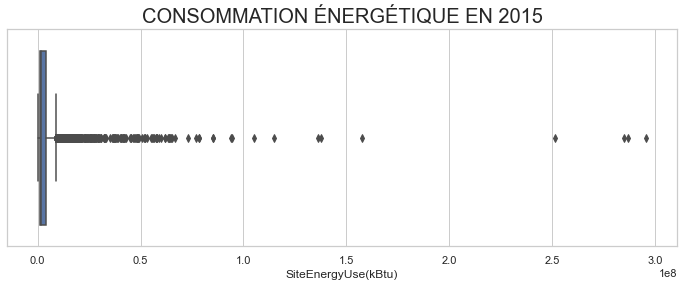

In [32]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(x=df_2015['SiteEnergyUse(kBtu)'])
plt.title('CONSOMMATION ÉNERGÉTIQUE EN 2015', fontsize=20);

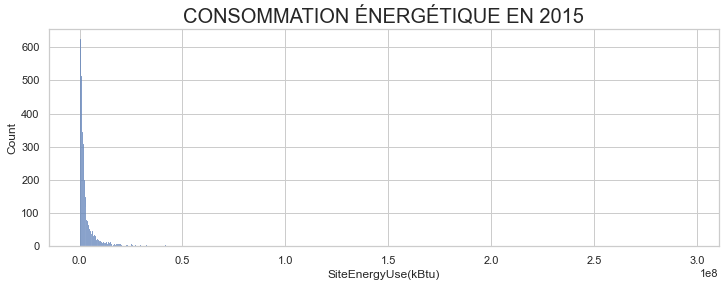

In [33]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.histplot(df_2015, x='SiteEnergyUse(kBtu)')
plt.title('CONSOMMATION ÉNERGÉTIQUE EN 2015', fontsize=20);

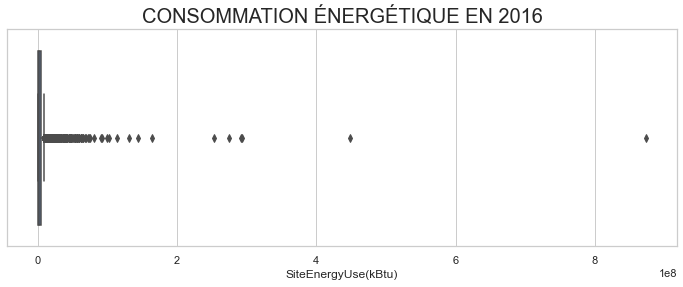

In [34]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(x=df_2016['SiteEnergyUse(kBtu)'])
plt.title('CONSOMMATION ÉNERGÉTIQUE EN 2016', fontsize=20);

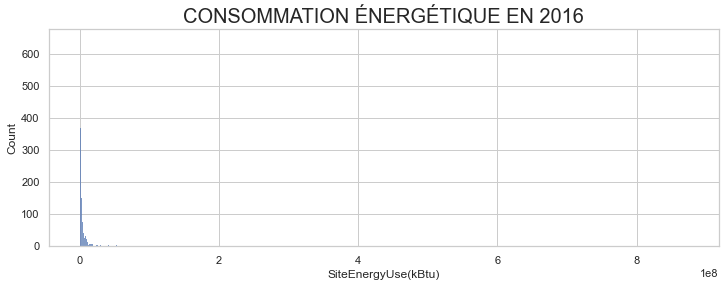

In [35]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.histplot(df_2016, x='SiteEnergyUse(kBtu)')
plt.title('CONSOMMATION ÉNERGÉTIQUE EN 2016', fontsize=20);

### Transformation logarithmique

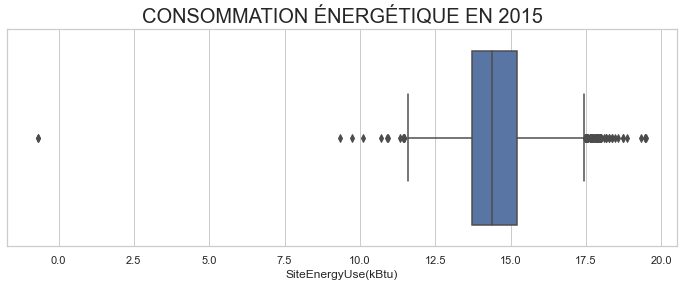

In [36]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(x=np.log(df_2015['SiteEnergyUse(kBtu)'] + 0.5))
plt.title('CONSOMMATION ÉNERGÉTIQUE EN 2015', fontsize=20);

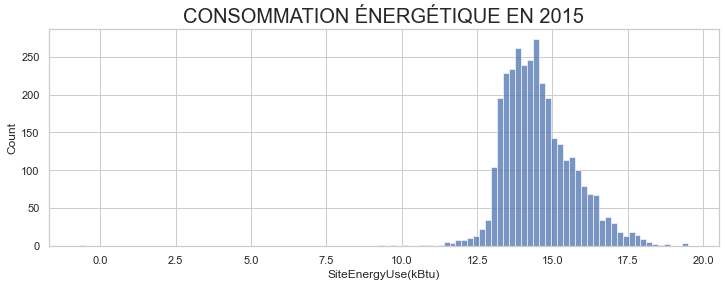

In [45]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.histplot(df_2015, x=np.log(df_2015['SiteEnergyUse(kBtu)'] + 0.5))
plt.title('CONSOMMATION ÉNERGÉTIQUE EN 2015', fontsize=20);

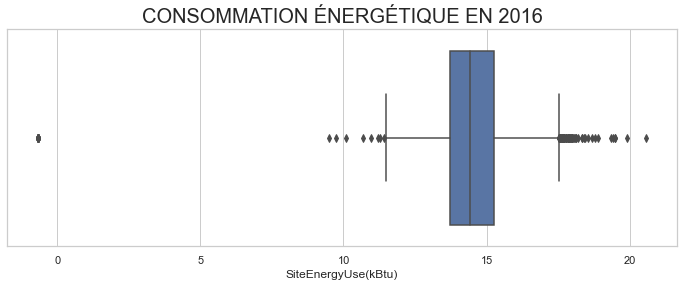

In [37]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(x=np.log(df_2016['SiteEnergyUse(kBtu)'] + 0.5))
plt.title('CONSOMMATION ÉNERGÉTIQUE EN 2016', fontsize=20);

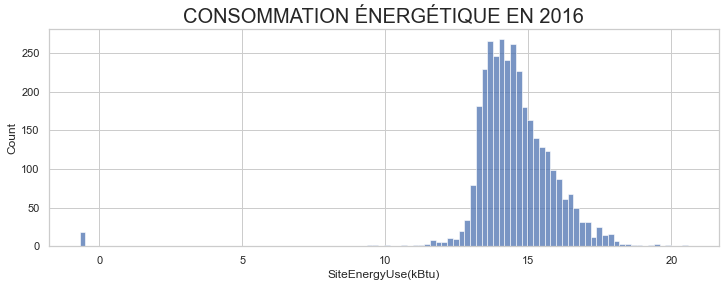

In [38]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.histplot(df_2016, x=np.log(df_2016['SiteEnergyUse(kBtu)'] + 0.5))
plt.title('CONSOMMATION ÉNERGÉTIQUE EN 2016', fontsize=20);

### Test de normalité (Shapiro-Wilk)  
    H0 : La distribtuion de SiteEnergyUse(kBtu) est normal.  
    H1 : La ditribution de SiteEnergyUse(kBtu) n'est pas normal

In [39]:
def shapiro_wilk(dataframe, feature):
    '''This function proceed to the Shapiro-Wilk test (for gaussian distribution).
    It takes a dataframe and the name of the feature to test.
    It filters for non-null vallues of the feature and print the results.'''
    
    # filtering non-null data for the feature
    mask = dataframe[feature].notnull()
    data_view = dataframe[mask][feature]

    # processing the Shopiro-Wilk test on the filtered data
    results = shapiro(data_view)

    # Print results
    print("Shapiro-Wilk test's statistic value is: W = {}".format(results[0]))
    print("Shapiro-Wilk test's p-value is: p = {}".format(results[1]))
    print("\nGaussian distribution hypothesis for \'{}\' can be rejected at a risk of {:.2f}%.".format(feature, results[1]*100))

In [40]:
shapiro_wilk(df_2015, 'SiteEnergyUse(kBtu)')

Shapiro-Wilk test's statistic value is: W = 0.2760465145111084
Shapiro-Wilk test's p-value is: p = 0.0

Gaussian distribution hypothesis for 'SiteEnergyUse(kBtu)' can be rejected at a risk of 0.00%.


In [41]:
shapiro_wilk(df_2016, 'SiteEnergyUse(kBtu)')

Shapiro-Wilk test's statistic value is: W = 0.15326350927352905
Shapiro-Wilk test's p-value is: p = 0.0

Gaussian distribution hypothesis for 'SiteEnergyUse(kBtu)' can be rejected at a risk of 0.00%.


### 6.b TotalGHGEmissions

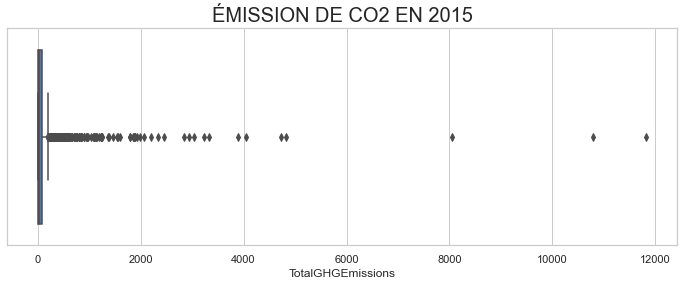

In [42]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(x=df_2015['TotalGHGEmissions'])
plt.title('ÉMISSION DE CO2 EN 2015', fontsize=20);

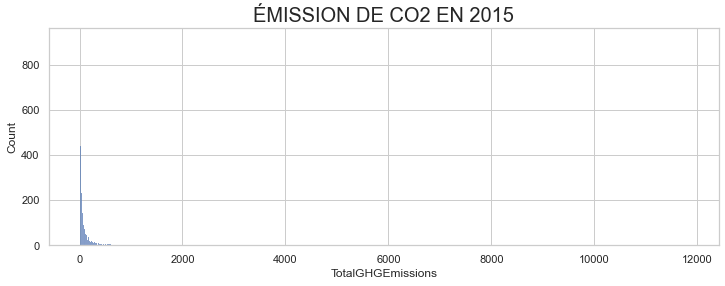

In [43]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.histplot(df_2015, x='TotalGHGEmissions')
plt.title('ÉMISSION DE CO2 EN 2015', fontsize=20);

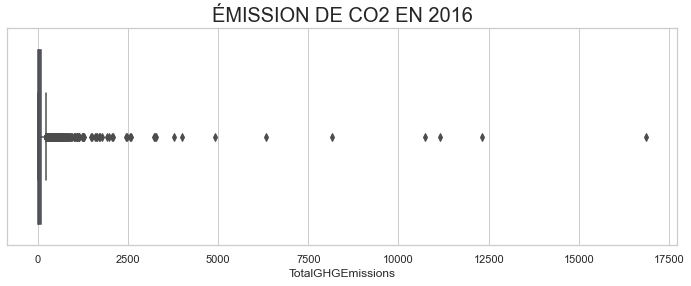

In [44]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(x=df_2016['TotalGHGEmissions'])
plt.title('ÉMISSION DE CO2 EN 2016', fontsize=20);

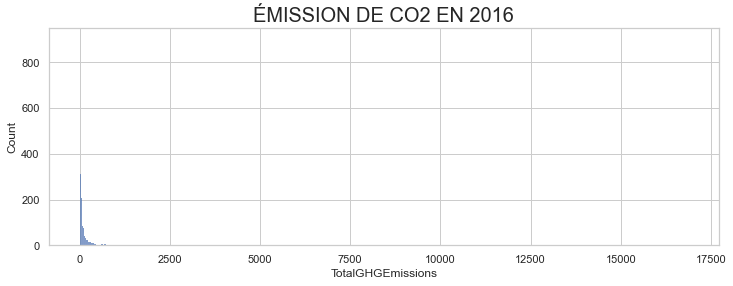

In [45]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.histplot(df_2016, x='TotalGHGEmissions')
plt.title('ÉMISSION DE CO2 EN 2016', fontsize=20);

### Transformation logarithmique

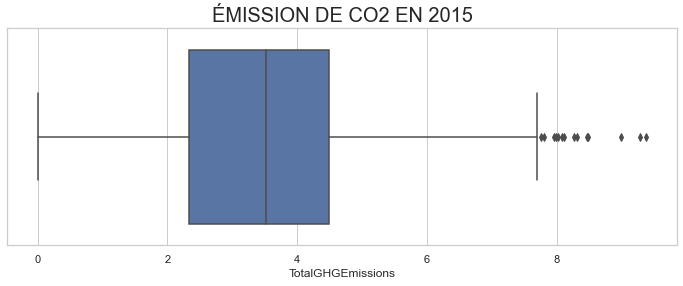

In [46]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(x=np.log(df_2015['TotalGHGEmissions'] + 1))
plt.title('ÉMISSION DE CO2 EN 2015', fontsize=20);

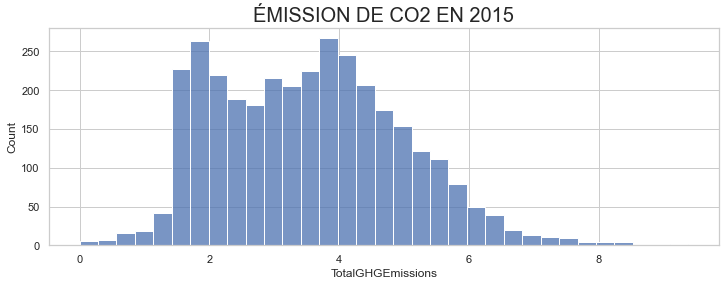

In [47]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.histplot(df_2015, x=np.log(df_2015['TotalGHGEmissions'] + 1))
plt.title('ÉMISSION DE CO2 EN 2015', fontsize=20);

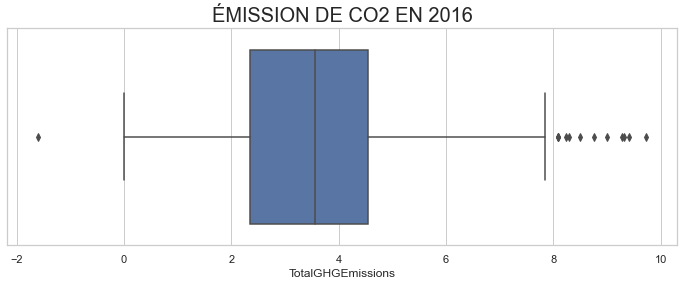

In [48]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(x=np.log(df_2016['TotalGHGEmissions'] + 1))
plt.title('ÉMISSION DE CO2 EN 2016', fontsize=20);

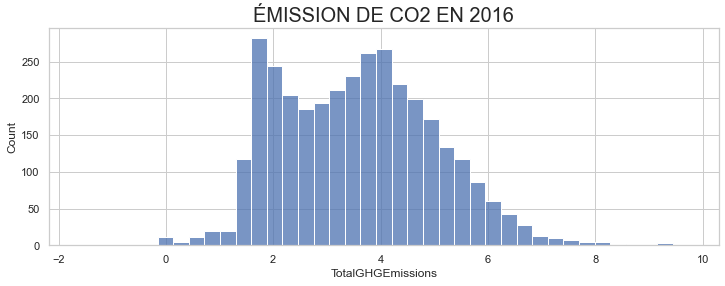

In [49]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.histplot(df_2016, x=np.log(df_2016['TotalGHGEmissions'] + 1))
plt.title('ÉMISSION DE CO2 EN 2016', fontsize=20);

### Test de normalité (Shapiro-Wilk)  
    H0 : La distribtuion de SiteEnergyUse(kBtu) est normal.  
    H1 : La ditribution de SiteEnergyUse(kBtu) n'est pas normal

In [50]:
shapiro_wilk(df_2015, 'TotalGHGEmissions')

Shapiro-Wilk test's statistic value is: W = 0.19610530138015747
Shapiro-Wilk test's p-value is: p = 0.0

Gaussian distribution hypothesis for 'TotalGHGEmissions' can be rejected at a risk of 0.00%.


In [51]:
shapiro_wilk(df_2016, 'TotalGHGEmissions')

Shapiro-Wilk test's statistic value is: W = 0.14604246616363525
Shapiro-Wilk test's p-value is: p = 0.0

Gaussian distribution hypothesis for 'TotalGHGEmissions' can be rejected at a risk of 0.00%.


## 7. SÉLECTION DES FEATURES

In [52]:
features_selected = {'BuildingType'
                    ,'ComplianceStatus' # état de conformité
                    ,'CouncilDistrictCode' # Propriété District municipal de la ville de Seattle
                    #,'DataYear' #?
                    ,'DefaultData'
                    #,'LargestPropertyUseType' # type de batiment --> primaryPropertyType
                    #,'LargestPropertyUseTypeGFA' #?  --> primaryPropertyType
                    ,'ListOfAllPropertyUseTypes' # all types
                    ,'Neighborhood' # qurtier
                    ,'NumberofBuildings'
                    ,'NumberofFloors'
                    ,'Outlier'
                    ,'PrimaryPropertyType'
                    ,'PropertyGFABuilding' #surface brute intérieure
                    ,'PropertyGFAParking'
                    ,'PropertyGFATotal'
                    ,'YearBuilt'
                    ,'Latitude'
                    ,'Longitude'} 

### 7.a Comparaison 2015 - 1016

C:\Users\t.favrel\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'EMISSION DE CO2 EN 2015 ET 2016')

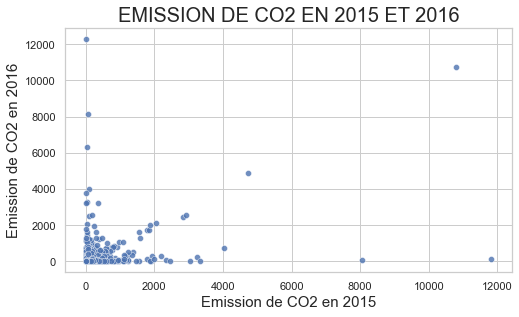

In [53]:
fig, ax = plt.subplots(figsize=(8, 4.5))

sns.scatterplot(df_2015.loc[df_2015['OSEBuildingID'].map(lambda x: x in ID_inter), 'TotalGHGEmissions']
               ,df_2016.loc[df_2016['OSEBuildingID'].map(lambda x: x in ID_inter), 'TotalGHGEmissions']
               ,alpha=0.8)

ax.set_xlabel('Emission de CO2 en 2015', fontsize=15)
ax.set_ylabel('Emission de CO2 en 2016', fontsize=15)
plt.title('EMISSION DE CO2 EN 2015 ET 2016', fontsize=20)

C:\Users\t.favrel\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, "CONSOMATION D'ÉNERGIE EN 2015 ET 2016")

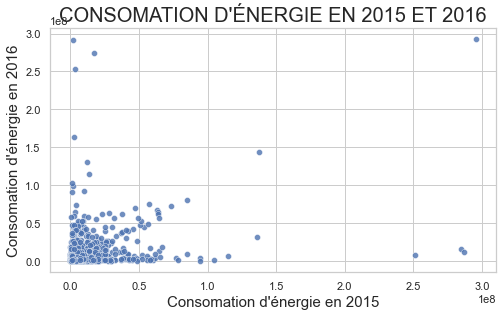

In [54]:
fig, ax = plt.subplots(figsize=(8, 4.5))

sns.scatterplot(df_2015.loc[df_2015['OSEBuildingID'].map(lambda x: x in ID_inter), 'SiteEnergyUse(kBtu)']
               ,df_2016.loc[df_2016['OSEBuildingID'].map(lambda x: x in ID_inter), 'SiteEnergyUse(kBtu)']
               ,alpha=0.8)

ax.set_xlabel('Consomation d\'énergie en 2015', fontsize=15)
ax.set_ylabel('Consomation d\'énergie en 2016', fontsize=15)
plt.title('CONSOMATION D\'ÉNERGIE EN 2015 ET 2016', fontsize=20)

In [71]:
df_2015.loc[df_2015['Outlier'].notnull() & df_2015['OSEBuildingID'].map(lambda x: x in ID_inter), 'SiteEnergyUse(kBtu)']

3       High Outlier
62       Low Outlier
228     High Outlier
322     High Outlier
387      Low Outlier
            ...     
3255     Low Outlier
3276     Low Outlier
3284     Low Outlier
3306    High Outlier
3326     Low Outlier
Name: Outlier, Length: 81, dtype: object

C:\Users\t.favrel\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, "CONSOMATION D'ÉNERGIE EN 2015 ET 2016")

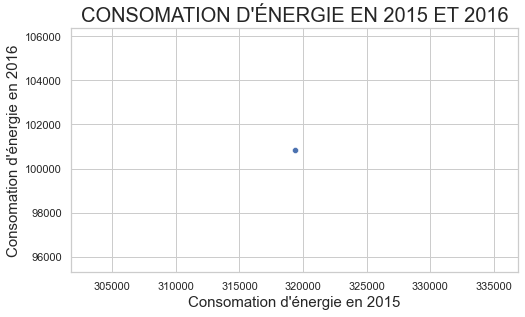

In [73]:
fig, ax = plt.subplots(figsize=(8, 4.5))

sns.scatterplot(df_2015.loc[df_2015['Outlier'].notnull() & df_2015['OSEBuildingID'].map(lambda x: x in ID_inter), 'SiteEnergyUse(kBtu)']
               ,df_2016.loc[df_2016['Outlier'].notnull() & df_2016['OSEBuildingID'].map(lambda x: x in ID_inter), 'SiteEnergyUse(kBtu)'])

ax.set_xlabel('Consomation d\'énergie en 2015', fontsize=15)
ax.set_ylabel('Consomation d\'énergie en 2016', fontsize=15)
plt.title('CONSOMATION D\'ÉNERGIE EN 2015 ET 2016', fontsize=20)

C:\Users\t.favrel\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, "CONSOMATION D'ÉNERGIE EN 2015 ET 2016")

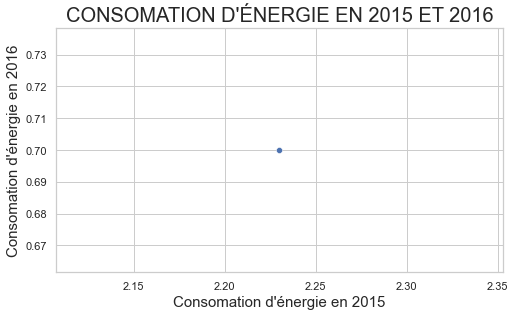

In [76]:
fig, ax = plt.subplots(figsize=(8, 4.5))

sns.scatterplot(df_2015.loc[df_2015['Outlier'].notnull() & df_2015['OSEBuildingID'].map(lambda x: x in ID_inter), 'TotalGHGEmissions']
               ,df_2016.loc[df_2016['Outlier'].notnull() & df_2016['OSEBuildingID'].map(lambda x: x in ID_inter), 'TotalGHGEmissions'])

ax.set_xlabel('Consomation d\'énergie en 2015', fontsize=15)
ax.set_ylabel('Consomation d\'énergie en 2016', fontsize=15)
plt.title('CONSOMATION D\'ÉNERGIE EN 2015 ET 2016', fontsize=20)

### 7.b Nettoyage des features utiles

In [55]:
#On concatène nos 2 df.
df = pd.concat([df_2015, df_2016], axis=0, join='outer',ignore_index = True)
df.shape

(6716, 52)

In [56]:
#Suppression de variables non utiles
df.drop(['SPD Beats', 'Seattle Police Department Micro Community Policing Plan Areas','City Council Districts',\
        'Zip Codes','2010 Census Tracts'], axis='columns', inplace=True)
df.shape

(6716, 47)

In [57]:
#Reccupération des commentaires pour extraire de l'information sur les récentes rénovations
pd.options.display.max_colwidth = 600
Commentaire = df[['OSEBuildingID','DataYear','Comments']][df['Comments'].notna()]
Commentaire

,OSEBuildingID,DataYear,Comments
62,87,2015,Under construction starting 6/2013 (old building demolished) and ending 9/2016. New Building re-opened 9/2016. Year built changed from 1948 to 2016.
436,594,2015,"Part of McKinstry's campus, property operates a fabrication and production shop and is conditioned by natural gas overhead radiant unit heaters with no cooling. Learn more at www.mckinstry.com."
437,595,2015,One of two office buildings on McKinstry's campus partially remodeled in 2009 from warehouse to office space. Served by rooftop air handling units with underfloor VAVs. Self-performed energy efficiency upgrades in 2015 include a long-term LED lighting re
595,792,2015,"Part of McKinstry’s campus, this remodeled warehouse is mainly office but includes a full-size basketball court and gym with locker rooms, bistro with a full kitchen, and data center. Served by rooftop package units for heating and cooling. Upgrades inclu"
719,19694,2015,Construction completed in mid 2015. The building was unoccupied for most of 2015.
1358,21570,2015,Under construction starting 6/2013 (old building demolished) and ending 9/2016. New Building re-opened 9/2016. Year built changed from 1950 to 2016.
1360,21578,2015,Under construction starting 6/2013 (old building demolished) and ending 9/2016. New Building re-opened 9/2016. Year built changed from 1949 to 2016.
1373,21616,2015,Under construction starting 6/2015 (old building demolished) and ending 9/2017. New Building re-opens 9/2017. Year built changed from 1954 to 2017.
2108,24408,2015,Under construction starting 09/2014 (old building demolished) and ending 9/2017. New Buildings (two) re-open 9/2017. Year built changed from 1953 to 2017.
2230,24780,2015,"Part of McKinstry's campus, the office space for this building sites on the 3rd floor above a 2-story parking garage and is served by rooftop package units for both heating and cooling. Learn more at www.mckinstryinnovationcenter.com."


In [58]:
# Drop duplicate : On garde uniquement les données sur une année quand elles sont disponibles sur les deux années.
df.drop_duplicates(subset = ['OSEBuildingID'], keep = 'last', inplace = True)
df.shape[0]

3432

In [59]:
# On Crée une variable où l'on notifie les bâtiments qui ont eu des travaux récents d'amélioriation de l'efficacité
df['RecentUpgrade'] = 'No'
#On sélectionne les index des batiments avec des travaux récents d'amélioration et on leur attribue la valeur Yes
Reno = df[(df['OSEBuildingID'] == 595) | (df['OSEBuildingID'] == 792) | (df['OSEBuildingID'] == 26240)].index.values
df.loc[Reno, 'RecentUpgrade'] = 'Yes'

In [60]:
df['Neighborhood'].unique()

array(['DOWNTOWN', 'DELRIDGE', 'LAKE UNION', 'GREATER DUWAMISH', 'EAST',
       'NORTHWEST', 'MAGNOLIA / QUEEN ANNE', 'SOUTHEAST', 'BALLARD',
       'NORTH', 'NORTHEAST', 'CENTRAL', 'Central', 'SOUTHWEST', 'Ballard',
       'North', 'Delridge', 'Northwest', 'DELRIDGE NEIGHBORHOODS'],
      dtype=object)

In [61]:
# On uniformise l'écriture pour ne pas avoir de doublons.
df['Neighborhood'] = df['Neighborhood'].str.capitalize()
Delridge = df.index[df['Neighborhood']== 'Delridge neighborhoods'].tolist()
df.loc[Delridge, 'Neighborhood'] = 'Delridge'
df['Neighborhood'].nunique()

13

In [62]:
df.groupby('PrimaryPropertyType')['OSEBuildingID'].nunique()

PrimaryPropertyType
Distribution Center              53
High-Rise Multifamily           105
Hospital                         10
Hotel                            77
K-12 School                     141
Laboratory                       10
Large Office                    176
Low-Rise Multifamily           1009
Medical Office                   42
Mid-Rise Multifamily            568
Mixed Use Property              134
Non-Refrigerated Warehouse        2
Office                            3
Other                           263
Refrigerated Warehouse           12
Residence Hall                   23
Restaurant                       12
Restaurant\n                      1
Retail Store                     94
Self-Storage Facility            28
Senior Care Community            45
Small- and Mid-Sized Office     300
Supermarket / Grocery Store      40
University                       25
Warehouse                       187
Worship Facility                 72
Name: OSEBuildingID, dtype: int64

In [63]:
# On réduit le nombre de primary property type pour augmenter l'efficacité des algo de prédiction.
print(" nombre avant transformation : " , df['PrimaryPropertyType'].nunique()  )

Restau = df.index[df['PrimaryPropertyType']== 'Restaurant\n'].tolist()
df.loc[Restau, 'PrimaryPropertyType'] = 'Restaurant'

Warehouse = df.index[df['PrimaryPropertyType']== 'Non-Refrigerated Warehouse'].tolist()
df.loc[Warehouse, 'PrimaryPropertyType'] = 'Warehouse'

Office = df.index[(df['PrimaryPropertyType']== 'Large Office') | \
                  (df['PrimaryPropertyType']== 'Small- and Mid-Sized Office') ].tolist()
df.loc[Office, 'PrimaryPropertyType'] = 'Office'

print(" nombre après transformation : " ,df['PrimaryPropertyType'].nunique())

 nombre avant transformation :  26
 nombre après transformation :  22


In [64]:
df['BuildingType'].unique()

array(['Multifamily LR (1-4)', 'NonResidential', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Nonresidential COS',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [65]:
df.groupby('Outlier')['OSEBuildingID'].nunique()

Outlier
High outlier     9
Low Outlier      3
Low outlier     23
Name: OSEBuildingID, dtype: int64

In [66]:
#Filtre sur les Outlier
No_Outlier = (df['Outlier'] != 'High Outlier') & (df['Outlier'] != 'Low Outlier') & (df['Outlier'] != 'High outlier') &\
(df['Outlier'] != 'Low outlier')
df = df[No_Outlier]
df.shape

(3397, 48)

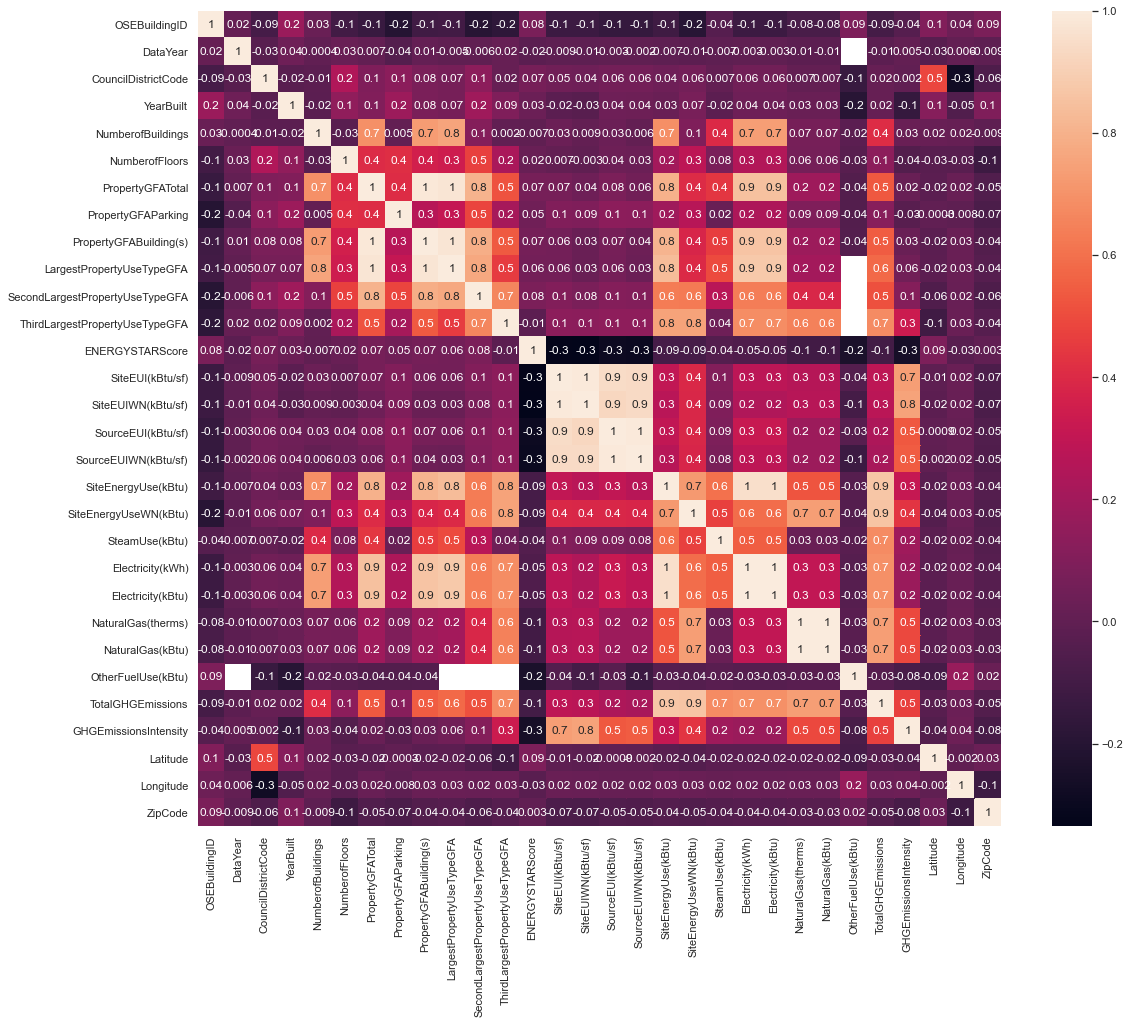

In [67]:
fig, ax = plt.subplots(figsize=(18, 15))

sns.heatmap(df.corr()
           ,annot=True
           ,fmt = '.1g');

In [82]:
features_selected

{'BuildingType',
 'ComplianceStatus',
 'CouncilDistrictCode',
 'DefaultData',
 'Latitude',
 'ListOfAllPropertyUseTypes',
 'Longitude',
 'Neighborhood',
 'NumberofBuildings',
 'NumberofFloors',
 'Outlier',
 'PrimaryPropertyType',
 'PropertyGFABuilding',
 'PropertyGFAParking',
 'PropertyGFATotal',
 'YearBuilt'}

In [84]:
df['ComplianceStatus'].unique()

array(['Compliant', 'Error - Correct Default Data', 'Missing Data',
       'Non-Compliant'], dtype=object)

In [110]:
df[(df['ComplianceStatus'] == 'Error - Correct Default Data') | (df['ComplianceStatus'] == 'Missing Data')]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode,RecentUpgrade,Age
3362,28,2016,SPS-District K-12,K-12 School,Graham Hill Elementary,1102000138,2,Southeast,1961,1.0,...,Error - Correct Default Data,NaN,47.54576,-122.26853,5149 S. Graham St.,Seattle,WA,98118.0,No,59
3368,34,2016,SPS-District K-12,K-12 School,Meany Building,0688000090,3,Central,1955,1.0,...,Missing Data,NaN,47.62266,-122.30547,301/300 21st Ave. E.,Seattle,WA,98112.0,No,65
3370,36,2016,SPS-District K-12,K-12 School,Jane Addams Middle,0752000170,5,North,1949,1.0,...,Error - Correct Default Data,NaN,47.70994,-122.29301,11051 34th Ave. N.E.,Seattle,WA,98125.0,No,71
3371,37,2016,SPS-District K-12,K-12 School,John Hay Elementary,0809000005,7,Magnolia / queen anne,1989,1.0,...,Missing Data,NaN,47.63290,-122.35172,201 Garfield St.,Seattle,WA,98109.0,No,31
3378,51,2016,SPS-District K-12,K-12 School,Eckstein Middle,0425049022,4,Northeast,1950,1.0,...,Error - Correct Default Data,NaN,47.68252,-122.29498,3003 N.E. 75th St.,Seattle,WA,98115.0,No,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6466,39332,2016,SPS-District K-12,K-12 School,South Shore K-8,2123700250,2,Southeast,2009,1.0,...,Error - Correct Default Data,NaN,47.52374,-122.27201,4800 S. Henderson,Seattle,WA,98118.0,No,11
6506,49703,2016,SPS-District K-12,K-12 School,Catharine Blaine K-8,2225039016,7,Magnolia / queen anne,1952,1.0,...,Missing Data,NaN,47.64342,-122.39970,2550 34th Ave. W.,Seattle,WA,98199.0,No,68
6706,50210,2016,Nonresidential COS,Office,Central West HQ / Brown Bear,2425039137,7,Magnolia / queen anne,1952,1.0,...,Error - Correct Default Data,NaN,47.63572,-122.37525,1403 w howe,Seattle,WA,NaN,No,68
6709,50220,2016,Nonresidential COS,Office,Genesee/SC SE HQ,4154300585,2,Southeast,1960,1.0,...,Error - Correct Default Data,NaN,47.56440,-122.27813,4420 S Genesee,Seattle,WA,NaN,No,60


In [85]:
df['CouncilDistrictCode'].unique()
# -> caté

array([7, 1, 2, 3, 5, 6, 4], dtype=int64)

In [87]:
df['DefaultData'].unique() #?

array(['No', 'Yes', False, True], dtype=object)

In [90]:
#df['ListOfAllPropertyUseTypes'].unique() #no

In [92]:
df['NumberofBuildings'].unique()

array([  1.,   7.,   3.,   0.,   2.,   4.,  27.,   6.,  11.,  14.,   9.,
        nan,   5.,   8.,  16.,  23.,  10., 111.])

In [98]:
df['NumberofFloors'].unique()

array([ 4.,  6.,  3.,  1., 15.,  5.,  2.,  7., 12., 11., 41., 10., 18.,
        8., 25.,  9., 33., 28., 19., 24., 20., 34.,  0., 16., 23., 17.,
       36., 22., 47., 29., 14., 49., 37., 42., 63., 13., 21., 55., 46.,
       30., 56., 26., 76., 27., 31., 99., 38., 39., 32., 40.])

In [99]:
df['PrimaryPropertyType'].unique()

array(['Low-Rise Multifamily', 'Retail Store', 'Office', 'Warehouse',
       'Medical Office', 'Other', 'Mid-Rise Multifamily', 'K-12 School',
       'Worship Facility', 'Restaurant', 'Mixed Use Property', 'Hotel',
       'University', 'Self-Storage Facility', 'Senior Care Community',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'High-Rise Multifamily'], dtype=object)

In [101]:
df['PropertyGFAParking'].describe()

count      3397.000000
mean       8226.327053
std       33182.586247
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      512608.000000
Name: PropertyGFAParking, dtype: float64

In [103]:
df['PropertyGFATotal'].describe()

count    3.397000e+03
mean     9.503131e+04
std      2.186743e+05
min      1.128500e+04
25%      2.849200e+04
50%      4.420200e+04
75%      9.109100e+04
max      9.320156e+06
Name: PropertyGFATotal, dtype: float64

In [104]:
df['YearBuilt']

47      1900
165     2007
204     1989
272     1906
312     1947
        ... 
6711    1990
6712    2004
6713    1974
6714    1989
6715    1938
Name: YearBuilt, Length: 3397, dtype: int64

In [105]:
df['Age'] = 2020 - df['YearBuilt']

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3397 entries, 47 to 6715
Data columns (total 49 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3397 non-null   int64  
 1   DataYear                         3397 non-null   int64  
 2   BuildingType                     3397 non-null   object 
 3   PrimaryPropertyType              3397 non-null   object 
 4   PropertyName                     3397 non-null   object 
 5   TaxParcelIdentificationNumber    3396 non-null   object 
 6   CouncilDistrictCode              3397 non-null   int64  
 7   Neighborhood                     3397 non-null   object 
 8   YearBuilt                        3397 non-null   int64  
 9   NumberofBuildings                3389 non-null   float64
 10  NumberofFloors                   3397 non-null   float64
 11  PropertyGFATotal                 3397 non-null   int64  
 12  PropertyGFAParking 

In [123]:
dill.dump_session('kernels/p4_explor_kernel.db')